In [1]:
#d={"q3dten":q3dtenL_,"th3dten":th3dtenL_,"w3d":w3dL_,"q3d":q3dL_,"th3d":th3dL_,"prs":prsL_}
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

with nc.Dataset("mcs_ten.nc") as f:
    q3dten=f.variables["q3dten"][:]
    th3dten=f.variables["th3dten"][:]
    w3d=f.variables["w3d"][:]
    q3d=f.variables["q3d"][:]
    th3d=f.variables["th3d"][:]
    prs=f.variables["prs"][:]
    #timeL=f.variables["time"][:]



In [2]:

with nc.Dataset('cm1out.nc','r') as f:
    zh=f['zh'][:]
    zf=f['zf'][:]
    xh=f['xh'][:]
    qr=f['qr'][:]

In [3]:
#print(th3d.shape)
#print(th3d[-1,100,5,:])
rho=prs/(287.05*th3d)
#print(rho[-1,100,5,:])
#print(prs[-1,100,5,:10])
zf=np.array([0.0, 0.125, 0.25, 0.37500003, 0.5, 0.625, 0.75000006, 0.87500006, 1.0, 1.125, 1.25, 1.3750001, 1.5000001, 1.6250001, 1.7500001, 1.8750001, 2.0, 2.125, 2.261364, 2.409091, 2.568182, 2.7386365, 2.9204547, 3.1136367, 3.318182, 3.534091, 3.761364, 4.0, 4.25, 4.5, 4.75, 5.0, 5.2500005, 5.5000005, 5.7500005, 6.0000005, 6.2500005, 6.5000005, 6.7500005, 7.0000005, 7.2500005, 7.5000005, 7.7500005, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.250001, 10.500001, 10.750001, 11.000001, 11.250001, 11.500001, 11.750001, 12.000001, 12.250001, 12.500001, 12.750001, 13.000001, 13.250001, 13.500001, 13.750001, 14.000001, 14.250001, 14.500001, 14.750001, 15.000001, 15.250001, 15.500001, 15.750001, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75])
q3dtot_tend=np.sum(q3dten[:,:,:,:,0:6],axis=-1)

In [4]:
dz=zf[1:]-zf[:-1]
it=-1
i1=60
j1=5
from numba import jit

dq_dt=q3dtot_tend[:,:,:,:].copy()*0.0
nz=dq_dt.shape[-1]
for k in range(nz-2,-1,-1):
    dq_dt[:,:,:,k]=dq_dt[:,:,:,k+1]+q3dtot_tend[:,:,:,k]*dz[k]*rho[:,:,:,k] # need a rho here
dq_dt=-dq_dt

In [5]:
nt,nx,ny,nz=dq_dt.shape
x_phy=np.stack([prs/1e5,(th3d-273.15),q3d[:,:,:,:,1:6].sum(axis=-1),q3d[:,:,:,:,0]],axis=-1)


In [6]:

print(dq_dt.max(),dq_dt.min())

0.00045944384 -3.9554848e-06


In [8]:
a=np.nonzero(dq_dt>0.1e-6)
print(len(a[0]))
fluxTb=np.zeros((120,210))
cfluxTb=np.zeros((120,210))
for it,i1,j1,k1 in zip(a[0],a[1],a[2],a[3]):
    it1=int((-x_phy[it,i1,j1,k1,1])+30)
    iq=int(x_phy[it,i1,j1,k1,2]/0.00005)
    #print(it1,iq,x_phy[it,i1,j1,k1,1],x_phy[it,i1,j1,k1,2])
    #stop
    if it1<0 or it1>119 or iq<0 or iq>209:
        continue
    fluxTb[it1,iq]+=dq_dt[it,i1,j1,k1]
    cfluxTb[it1,iq]+=1
    
fluxTb[cfluxTb>0]=fluxTb[cfluxTb>0]/cfluxTb[cfluxTb>0]

9472432


In [9]:
import numpy as np
aq=np.nonzero(q3d[:,:,:,:,0]>0.1e-6)
print(len(aq[0]))
cond=np.zeros((120,180))
ccond=np.zeros((120,180))
import saturation as sat
mccount=0
dccount=0
sat_ratio=[]
cond_qvqvs=np.zeros((120,180))
np1=10000000
xL=[]
yL=[]
ymL=[]
for it,i1,j1,k1 in zip(aq[0][:np1],aq[1][:np1],aq[2][:np1],aq[3][:np1]):
    qvs,qvi = sat.saturation(th3d[it,i1,j1,k1],prs[it,i1,j1,k1])
    xL.append([q3d[it,i1,j1,k1,0]/qvs,q3d[it,i1,j1,k1,0]/0.001,(th3d[it,i1,j1,k1]-273.15)/10,\
              prs[it,i1,j1,k1]/1e5,q3d[it,i1,j1,k1,1:6].sum()/0.001])
    ymL.append([q3dten[it,i1,j1,k1,0],th3dten[it,i1,j1,k1],w3d[it,i1,j1,k1]])
    yL.append([q3dten[it,i1,j1,k1,0]])
    if q3dten[it,i1,j1,k1,0]<0:
        mccount+=1
        qvs,qvi = sat.saturation(th3d[it,i1,j1,k1],prs[it,i1,j1,k1])
        sat_ratio.append(q3d[it,i1,j1,k1,0]/qvs)
        cond[it1,iq]+=q3dten[it,i1,j1,k1,0]
        cond_qvqvs[it1,iq]+=q3d[it,i1,j1,k1,0]/qvs
        ccond[it1,iq]+=1

cond[ccond>0]=cond[ccond>0]/ccond[ccond>0]
cond_qvqvs[ccond>0]=cond_qvqvs[ccond>0]/ccond[ccond>0]


26419200


In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
xL=np.array(xL)
yL=np.array(yL)
ymL=np.array(ymL)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test,ym_train,ym_test = train_test_split(xL, yL[:,0], ymL,test_size=0.2, random_state=0)
histGradRegressor=HistGradientBoostingRegressor(max_iter=3000,max_bins=255,learning_rate=0.1)
#histGradRegressor.fit(x_train,y_train)

In [ ]:
#gradBoostingRegressor=GradientBoostingRegressor(max_depth=10,n_estimators=1000,learning_rate=0.1)
#gradBoostingRegressor.fit(x_train,y_train)
#print(dir(histGradRegressor))
print(histGradRegressor.max_bins)
print(histGradRegressor.max_depth)
import lightgbm as lgb 

lgb_model=lgb.LGBMRegressor(max_depth=10,n_estimators=1000,learning_rate=0.1)
lgb_model.fit(x_train,y_train*2e3)



[[1.         0.97307957]
 [0.97307957 1.        ]]
-1.3483842e-06 -1.352058226698528e-06
['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_base_doc', '_best_iteration', '_best_score', '_check_feature_names', '_check_n_features', '_class_map', '_class_weight', '_classes', '_estimator_type', '_evals_result', '_get_param_names', '_get_tags', '_more_tags', '_n_classes', '_n_features', '_n_features_in', '_objective', '_other_params', '_process_n_jobs', '_process_params', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', 'best_iteration_', 'best_score_', 'booster_', 'boosting_type', 'class_weight', 'colsample

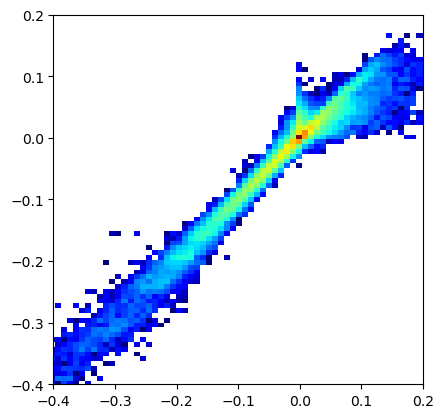

In [92]:
#plt.hist(sat_ratio,bins=100)


In [11]:
from catboost import CatBoostRegressor
cat_model2 = CatBoostRegressor(iterations=500,
                          learning_rate=0.1,
                          loss_function= 'MultiRMSE', 
                          eval_metric='MultiRMSE', 
                          depth=10)
print(ym_train.std(axis=0))
ym_std=ym_train.std(axis=0)
ym_train_scaled=ym_train.copy()/ym_std
cat_model2.fit(x_train,ym_train_scaled[:,0:2],verbose=True)

[1.2673428e-05 3.8572364e-02 1.6264565e+00]
0:	learn: 1.3079533	total: 1.31s	remaining: 10m 51s
1:	learn: 1.2046066	total: 1.9s	remaining: 7m 52s
2:	learn: 1.1116432	total: 2.45s	remaining: 6m 45s
3:	learn: 1.0304447	total: 2.97s	remaining: 6m 7s
4:	learn: 0.9576931	total: 3.47s	remaining: 5m 43s
5:	learn: 0.8950065	total: 3.98s	remaining: 5m 27s
6:	learn: 0.8382602	total: 4.48s	remaining: 5m 15s
7:	learn: 0.7873509	total: 4.97s	remaining: 5m 5s
8:	learn: 0.7430209	total: 5.47s	remaining: 4m 58s
9:	learn: 0.7048513	total: 5.96s	remaining: 4m 52s
10:	learn: 0.6722560	total: 6.47s	remaining: 4m 47s
11:	learn: 0.6410373	total: 6.97s	remaining: 4m 43s
12:	learn: 0.6143486	total: 7.47s	remaining: 4m 39s
13:	learn: 0.5924311	total: 7.97s	remaining: 4m 36s
14:	learn: 0.5725888	total: 8.47s	remaining: 4m 34s
15:	learn: 0.5543124	total: 8.98s	remaining: 4m 31s
16:	learn: 0.5397655	total: 9.5s	remaining: 4m 30s
17:	learn: 0.5267834	total: 10s	remaining: 4m 28s
18:	learn: 0.5155129	total: 10.5s	r

In [12]:
cat_model2.save_model('cat_model2.json',format='json')
import pickle
pickle.dump({"ym_std":ym_std},open('ym_std.pkl','wb'))

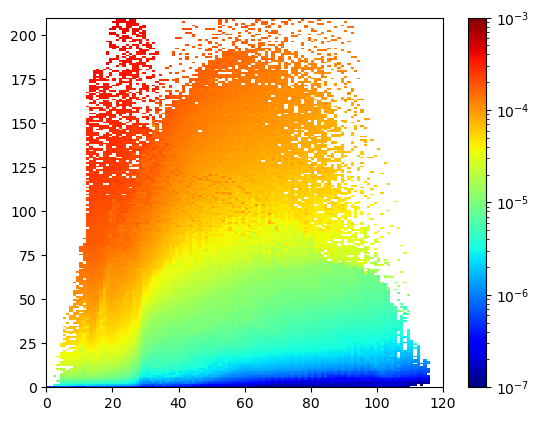

In [13]:
cfluxTb.max()

import matplotlib
plt.pcolormesh(fluxTb.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-7,vmax=1e-3))
plt.colorbar()

In [14]:
a0=[[],[]]
x=[]
y=[]
for i in range(120):
    for j in range(210):
        if cfluxTb[i,j]>0:
            x.append([i,j])
            y.append(fluxTb[i,j])
        else:
            a0[0].append(i)
            a0[1].append(j)
a0=np.array(a0)


(2, 9525)


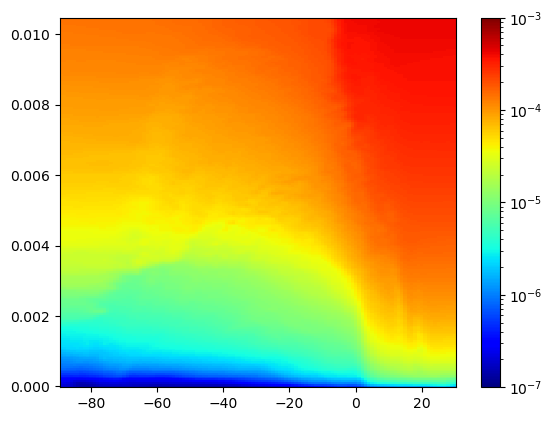

In [15]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

knn=KNeighborsRegressor(n_neighbors=10)
knn.fit(x,y)
print(a0.shape)
y_pred=knn.predict(a0.T)

fluxTb_interp=fluxTb.copy()
fluxTb_interp[a0[0],a0[1]]=y_pred
#plt.pcolormesh(fluxTb_interp.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-7,vmax=1e-3))
from scipy.ndimage import gaussian_filter
fluxTb_interp=gaussian_filter(fluxTb_interp,sigma=1)
temp_def=30-np.arange(120)
q_def=0.00005*np.arange(210)
plt.pcolormesh(temp_def,q_def,fluxTb_interp.T,cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-7,vmax=1e-3))
plt.colorbar()

In [16]:
import xarray as xr

ds=xr.Dataset({'fluxTable':(['temp','q'],fluxTb_interp)},coords={'temp':temp_def,'q':q_def}) 
ds.to_netcdf('precipFluxTable.nc')

In [17]:
r=np.random.random(len(a[0]))
b=np.nonzero(r<0.2)
y1=[]
y2=[]
for it,i1,j1,k1 in zip(a[0][b],a[1][b],a[2][b],a[3][b]):
    it1=int((-x_phy[it,i1,j1,k1,1])+30)
    iq=int(x_phy[it,i1,j1,k1,2]/0.00005)
    
    if iq<0:
        iq=0
    if iq>179:
        iq=179
    if it1<0:
        it1=0
    if it1>119:
        it1=199
    y1.append(fluxTb_interp[it1,iq])
    y2.append(dq_dt[it,i1,j1,k1])

In [102]:
print(np.corrcoef(y1,y2))

[[1.         0.95620942]
 [0.95620942 1.        ]]


In [25]:

training_set = TensorDataset(torch.from_numpy(x_train[a[0],:]).float(), torch.from_numpy(y_train[a[0],:]).float())
data_loader = DataLoader(training_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

In [82]:
#import optimizer
from torch import optim
# define optimizer
optimizer = optim.Adam(model_sed.parameters(), lr=0.001)
# define loss function
loss=nn.MSELoss()
# define number of epochs
n_epochs = 1
# empty list to store training losses
train_losses = []
# training loop
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data, target in data_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_sed(data)
        # calculate the loss
        target=target.squeeze()
        loss_output=loss(output.squeeze(), target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss_output.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss_output.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(data_loader.dataset)
    train_losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 0.000240


In [122]:

q1=q0.copy()
qL=[]
import tqdm
for it in tqdm.tqdm(range(300)):
    #flux=((10**y_test_-1)*1e-4)[:,::-1]
    flux=((10**nn_fluxes-1)*1e-4).reshape(x2d_iterated.shape[0],64)
    for i in range(62,-1,-1):
        q1[:,i]=q0[:,i]+2*(-flux[:,i]+flux[:,i+1])/dz[i]/rho_avg[i]
    q1[:,63]=q0[:,63]-2*flux[:,63]/dz[63]
    q1[q1<0]=0
    x2d_iterated[:,:,2]=np.log10(1+q1/1e-4)[:]
    x_test_iterated=np.reshape(x2d_iterated,(x2d_iterated.shape[0]*64,-1))
    nn_fluxes=model_sed2(torch.from_numpy(x_test_iterated).float())[:,0].detach().numpy()
    q0=q1.copy()
    if it%10==0:
        qL.append(q0.mean(axis=0))

100%|██████████| 300/300 [00:58<00:00,  5.12it/s]


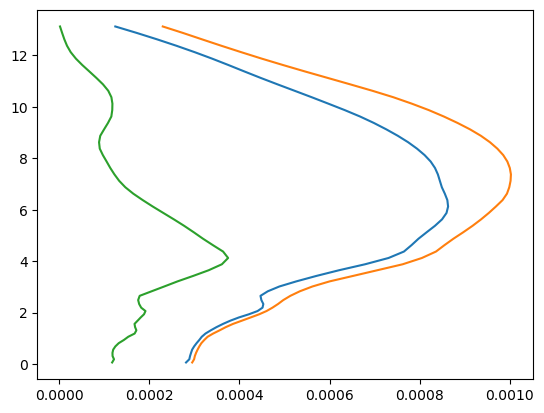

In [125]:
plt.plot(np.array(qL)[:7,:].mean(axis=0),zh[:64])
plt.plot(np.array(qL)[:1,:].mean(axis=0),zh[:64])
plt.plot(np.array(qL)[-2:,:].mean(axis=0),zh[:64])

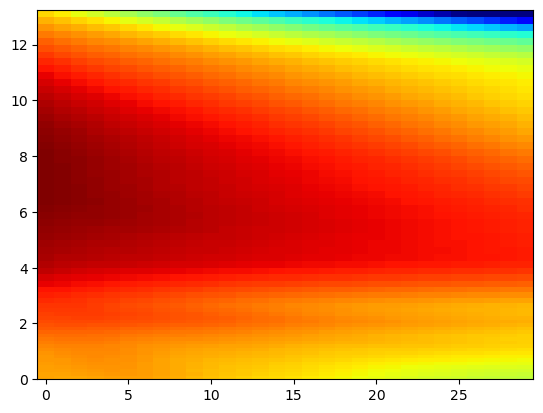

In [112]:
#print(x_reshaped.shape)
#plt.plot(qL[-1],zh[:64])
#plt.plot(zh[:64],x_reshaped[0,:64,2])
plt.pcolormesh(range(len(qL)),zh[:64],np.array(qL).T,cmap="jet",norm=matplotlib.colors.LogNorm(vmax=0.001,vmin=0.00001))

In [53]:
print(flux.shape)
print(q1.shape)

(61440, 64, 1)
(61440, 64)
